In [1]:
import json
import uuid
import os
import shutil
from rich.progress import track

#### Labelisation

In [5]:
def generate_unique_id():
    return str(uuid.uuid4())

def img_annot_to_ner_tags(json_data, img, header):
    ner_tags_output = {
        "id": generate_unique_id(),
        "tokens": [],
        "bboxes": [],
        "ner_tags": [],
        "image": None
    }

    # Extracting data from the JSON
    dates_1_textes = json_data["table"]["donnees"]["dates_1"]["textes"]
    dates_2_textes = json_data["table"]["donnees"]["dates_2"]["textes"]
    libelles_textes = json_data["table"]["donnees"]["libelles"]["textes"]
    debits_textes = json_data["table"]["donnees"]["debits"]["textes"]
    credits_textes = json_data["table"]["donnees"]["credits"]["textes"]
    libelles_tokens = json_data["table"]["donnees"]["libelles"]["token_positions"]

    if 'autres' in json_data["table"]["donnees"].keys():
        autres_textes = json_data["table"]["donnees"]["autres"]["textes"]
        autres_coords = json_data["table"]["donnees"]["autres"]["positions"]
 


    # Image
    ner_tags_output["image"] = img
    # libelles
    for libelle_text in libelles_textes:
        ner_tags_output["tokens"].extend(libelle_text.replace('\n', ' ').split())
        
    for token_libelle in libelles_tokens:
        ner_tags_output["bboxes"].extend(token_libelle)
    if (len(ner_tags_output["bboxes"]) != len(ner_tags_output["tokens"])):
        stop = False
        while not stop:
            ner_tags_output["tokens"].pop() # Résoudre le porblème de la dernière ligne du libelles
            if len(ner_tags_output["bboxes"]) == len(ner_tags_output["tokens"]):
                stop = True
    lib_tags = ["I-libelle"]*len(ner_tags_output["tokens"])
    lib_tags[0] = 'B-libelle'
    lib_tags[-1] = 'O-libelle'
    ner_tags_output["ner_tags"].extend(lib_tags)
    # Inside Outside Begin
    # date
    for i in range(len(dates_1_textes)):
        # Add tokens and corresponding ner_tags for dates
        date_text = dates_1_textes[i]
        date_position = json_data["table"]["donnees"]["dates_1"]["positions"][i]
        if date_text:
            ner_tags_output["tokens"].append(date_text)
            ner_tags_output["ner_tags"].append("S-date")
            ner_tags_output["bboxes"].append(date_position)
    
    for i in range(len(dates_2_textes)):
        # Add tokens and corresponding ner_tags for dates
        date_text = dates_2_textes[i]
        date_position = json_data["table"]["donnees"]["dates_2"]["positions"][i]
        if date_text:
            ner_tags_output["tokens"].append(date_text)
            ner_tags_output["ner_tags"].append("S-date")
            ner_tags_output["bboxes"].append(date_position)



    for i in range(len(credits_textes)):
    # Add tokens and corresponding ner_tags for credits
        credit_text = str(credits_textes[i]) if credits_textes[i] is not None else ""
        credit_position = json_data["table"]["donnees"]["credits"]["positions"][i]
        if credit_text:
            ner_tags_output["tokens"].append(credit_text)
            ner_tags_output["ner_tags"].append("S-credit")
            ner_tags_output["bboxes"].append(credit_position)
    for i in range(len(debits_textes)):
        debit_text = str(debits_textes[i]) if debits_textes[i] is not None else ""
        debit_position = json_data["table"]["donnees"]["debits"]["positions"][i]
        if debit_text:
            ner_tags_output["tokens"].append(debit_text)
            ner_tags_output["ner_tags"].append("S-debit")
            ner_tags_output["bboxes"].append(debit_position)

    
    ner_tags_output['tokens'].extend(header['tokens'])
    ner_tags_output['ner_tags'].extend(header['ner_tags'])
    ner_tags_output['bboxes'].extend(header['bboxes'])

    if 'autres' in json_data["table"]["donnees"].keys():
        # autres
        ner_tags_output['tokens'].extend(autres_textes)
        ner_tags_output['ner_tags'].extend(['O']*len(autres_textes))
        ner_tags_output['bboxes'].extend(autres_coords)


    try :
        assert len(ner_tags_output['tokens']) == len(ner_tags_output['ner_tags']) and len(ner_tags_output['tokens']) == len(ner_tags_output['bboxes'])
    except:
        print(json_data['image_id'])
        print (len(ner_tags_output['tokens']))
        print(len(ner_tags_output['ner_tags']))
        print(len(ner_tags_output['bboxes']))
        print('--------------------')
  
    # add_header
    return ner_tags_output
# [1, 2, 3]

# [4, 5]

# append(a, b) ==> [1,2,3 [4,5]]
# extend(a,b) ==> [1,2,3,4,5]

In [14]:
# ['B-other']*len([1,2,3])

['B-other', 'B-other', 'B-other']

In [3]:
def ner_tags(input_path, output_path):
    # Iterate through each subfolder
    
    for folder_name in track(os.listdir(input_path), description='Processing...'):
        folder_path = os.path.join(input_path, folder_name)
        # Check if it's a directory
        if os.path.isdir(folder_path):
            # Get list of images in the 'images' subfolder
            images_folder = os.path.join(folder_path, 'images')
            image_files = [f for f in os.listdir(images_folder) if os.path.isfile(os.path.join(images_folder, f))]

            annotations_folder = os.path.join(folder_path, 'annotations')
            annotations_files = [f for f in os.listdir(annotations_folder) if os.path.isfile(os.path.join(annotations_folder, f))]

            for i, annotation_file in enumerate(annotations_files):
                image_path = os.path.join(images_folder, image_files[i])
                #img = Image.open(image_path)
                annotation_path = os.path.join(annotations_folder, annotation_file)
                
                with open(annotation_path, 'r') as f:
                    # print(f)
                    json_data = json.load(f)
                
                header_path = f"./headers/{json_data['image_id'].split('_')[0]}.json"
                with open(header_path, 'r') as f:
                    header_data = json.load(f)

                output =  img_annot_to_ner_tags(json_data=json_data, img = image_path, header=header_data)

                # Save to a JSON file

                m_path = os.path.join(output_path, 'annotations', f"{annotation_file}")

                if not os.path.exists('{}/annotations'.format(output_path)):
                    os.makedirs('{}/annotations'.format(output_path))

                with open(m_path, "w") as output_file:
                    json.dump(output, output_file, indent=2)
                
                if not os.path.exists('{}/images'.format(output_path)):
                    os.makedirs('{}/images'.format(output_path))

                dest_path = os.path.join(output_path, 'images', json_data['image_id'])
                shutil.copy(image_path, dest_path)


In [7]:
input_path = "./data/training_data/"
output_path = "./annotated_data/train/"
ner_tags(input_path, output_path)

Output()

In [9]:
from PIL import Image, ImageDraw, ImageFont

In [10]:
# draw results onto the image
label2color = {
    "B-libelle": "blue",
    "B-debit": "red",
    "B-credit": "green",
    "B-date": "purple",
    "B-other" : 'black'
}
def draw_boxes(image, boxes, ner_tags):
    # width, height = image.size
    # normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

    normalizes_boxes = boxes
    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(ner_tags, normalizes_boxes):
        if prediction == "O":
            continue
        box = [int(b) for b in box]
        draw.rectangle(box, outline="black")
        #print(box)
        draw.rectangle(box, outline=label2color[prediction])
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
    return image

In [30]:
bank = 'hsbc'
def load_image(image_path):
    with Image.open(image_path).convert("RGB") as image:
        w, h = image.size
    return image, (w, h)

image,(w, h) = load_image(f'./annotated_data/train/images/{bank}_image_1.png')

In [45]:
# ner_tags_output['tokens'].extend(header['tokens'])
# ner_tags_output['ner_tags'].extend(header['ner_tags'])
# ner_tags_output['bboxes'].extend(header['bboxes'])
bank = 'sg'
header_path = f"./headers/{bank}.json"
with open(header_path, 'r') as f:
    header_data = json.load(f)

print(len(header_data['tokens']))
print(len(header_data['bboxes']))
print(len(header_data['ner_tags']))



197
197
197


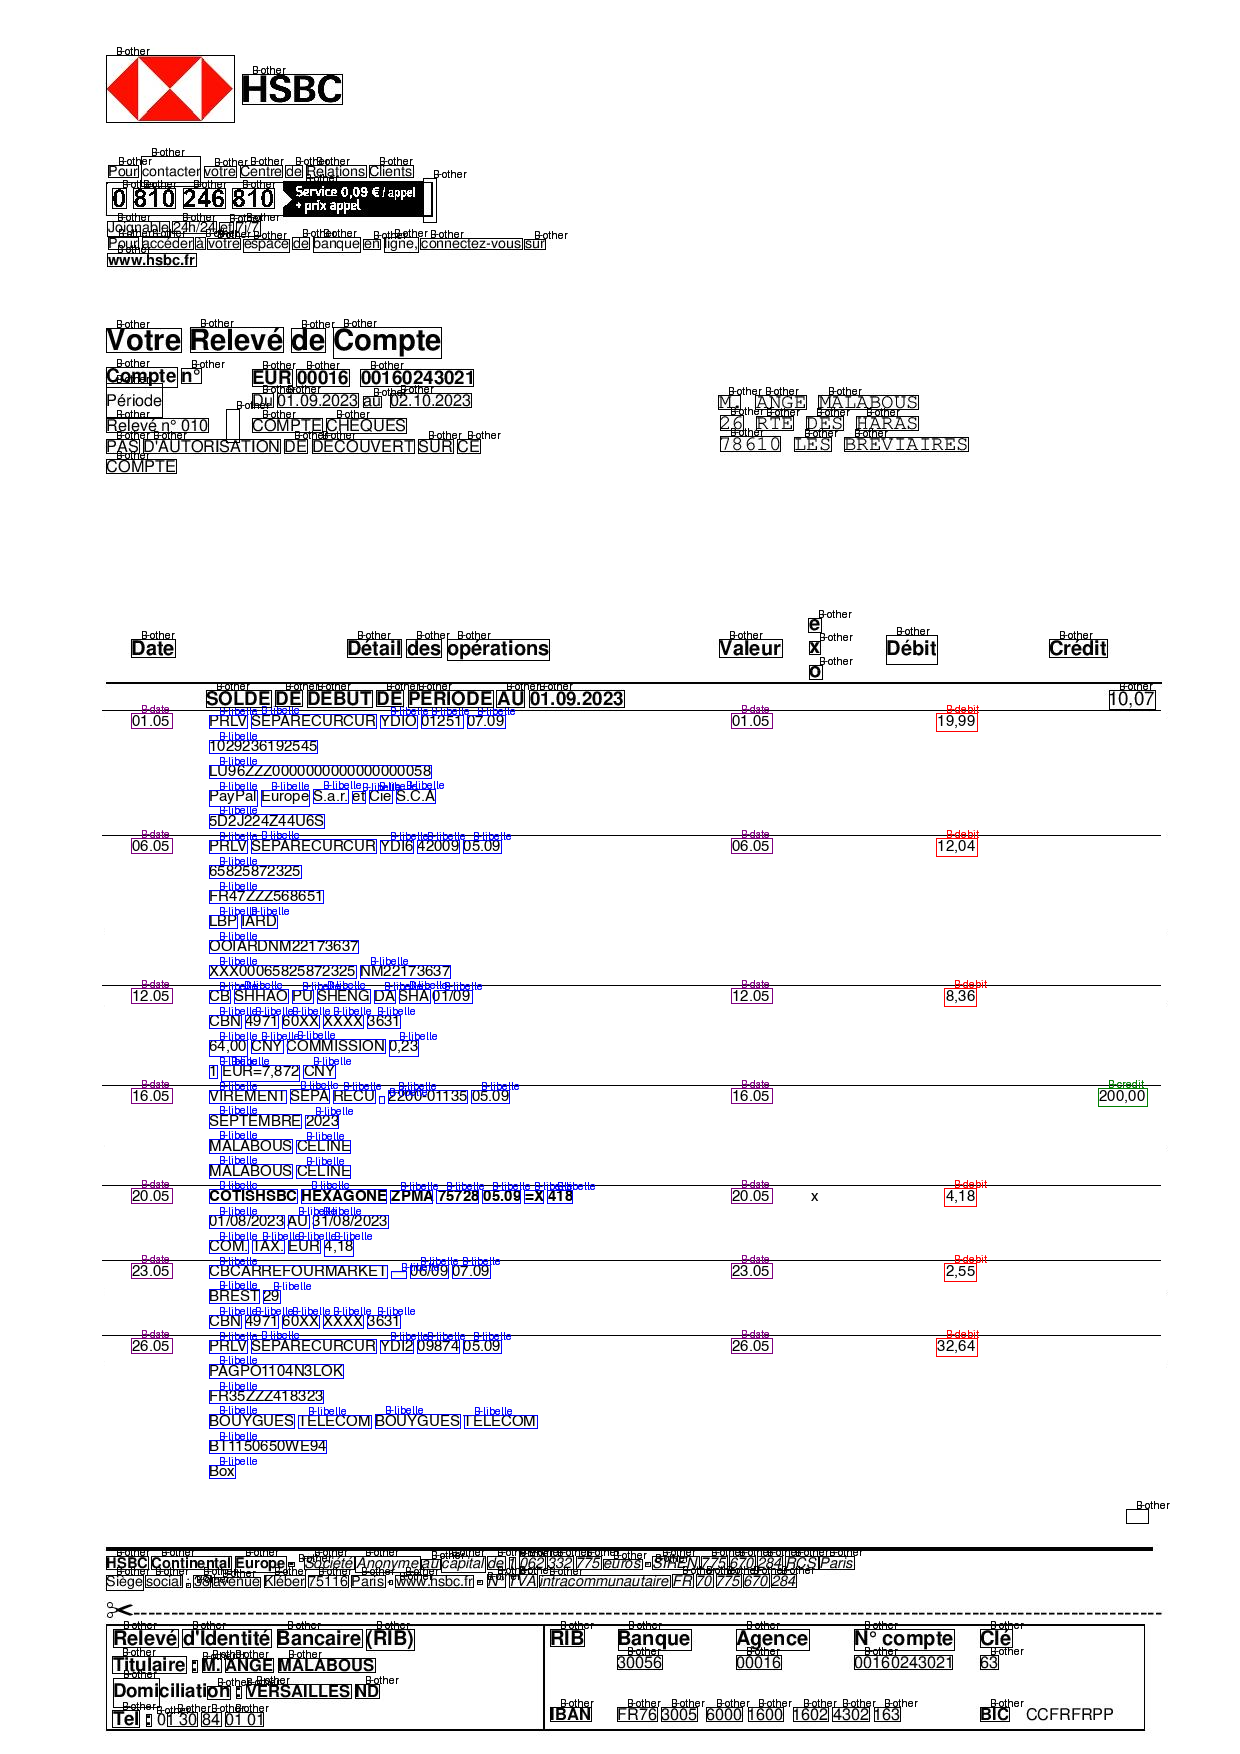

In [41]:
json_data_path = f'./annotated_data/train/annotations/{bank}_image_1.json'

with open(json_data_path, 'r') as f:
    json_data = json.load(f)

# annoter toutes les dates
# Recreer CMB mais s'assurer que les debits ne sont pas nulles
draw_boxes(image, json_data['bboxes'], json_data['ner_tags'])

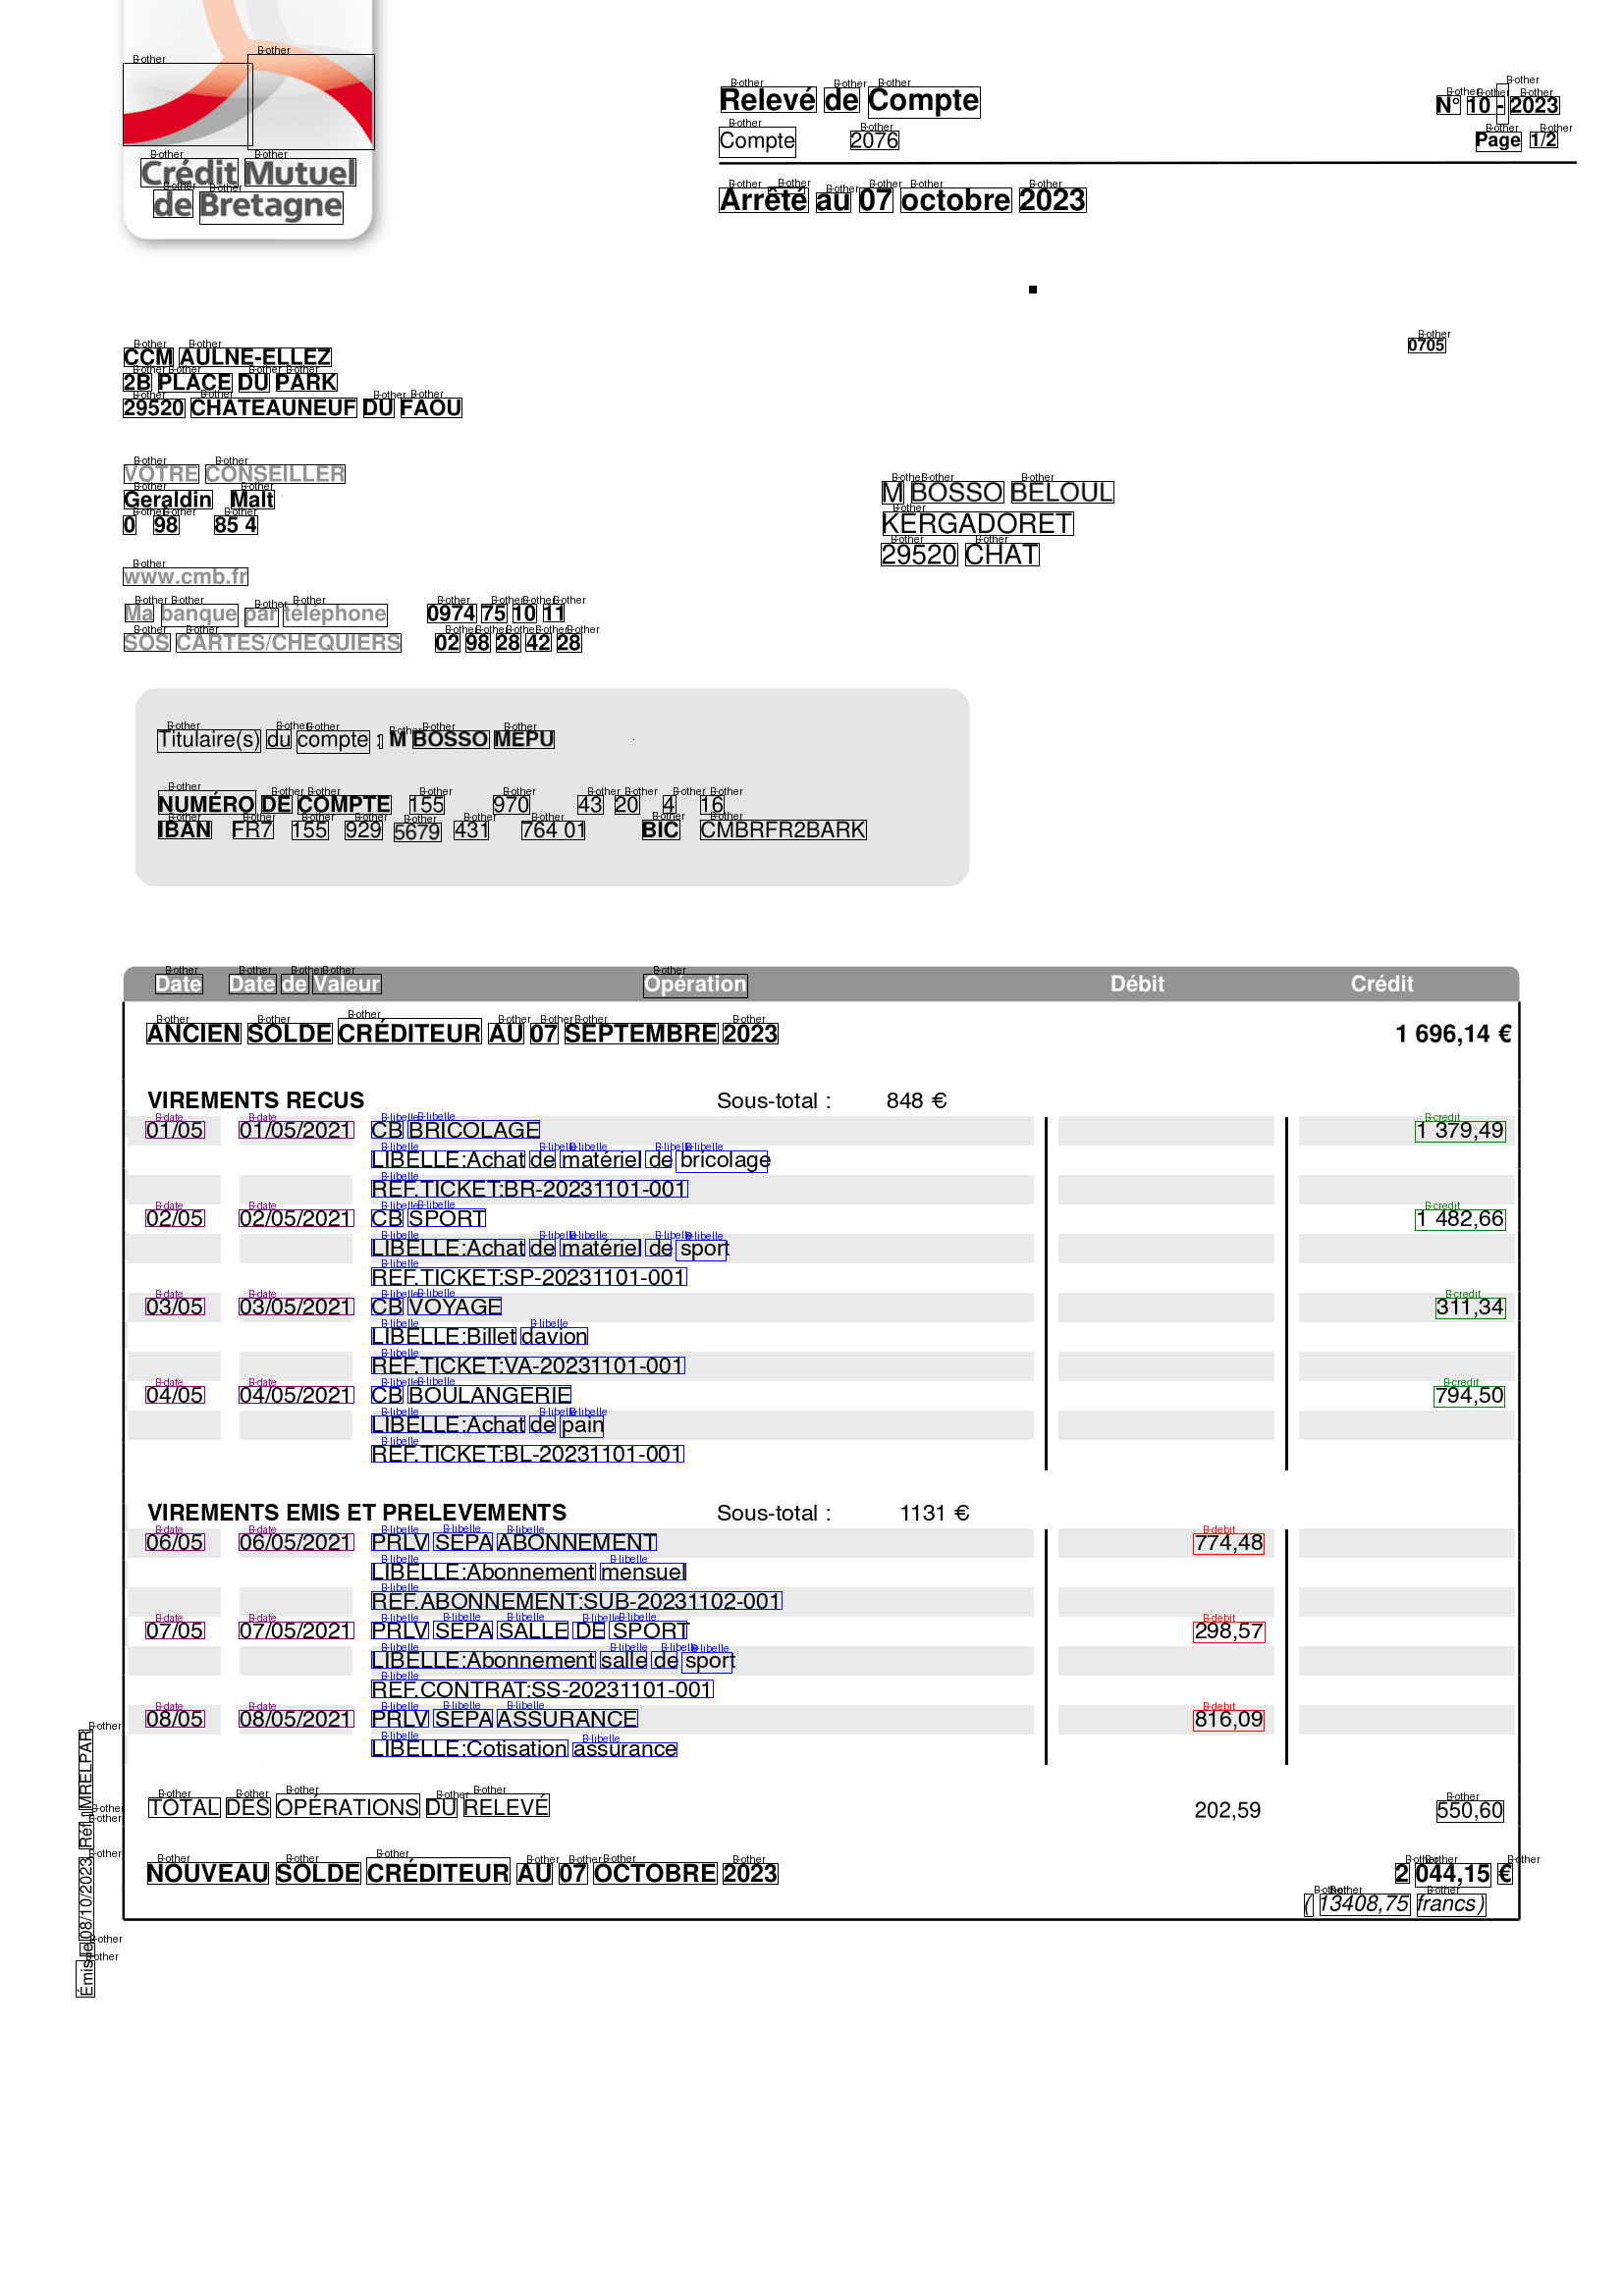